## CS6650 Homework 1 (Holi 2023 Semester)
#### Smartphone based Photoplethysmography (PPG)
The task is to develop a PPG system using a smartphone device to capture blood flow related imagery data and post-process such data to estimate the pulse or heart beat rate of the subject. You need to implement various features pertaining to the above task in this notebook. Create a directory, <b><your_roll>_CS6650H23</b>. Place this notebook in that directory.

#### A. Warmup - Data Collection [10 points]
Use your smartphone’s camera to capture the blood-flow video. Turn on the flash while recording and turn it off once done. Capture the video using the maximum frame rate that is available in your phone (e.g.60 fps or 30 fps). The same holds for image resolution. The captured videos are saved on the device’s SD card. Collect 3 such videos (each exactly 10 seconds long, if longer just limit to N frames while processing, where N = 10*frames_per_second) under the following conditions. Make sure that all video capture configurations are kept the same across the cases (resolution, fps).
* resting on bed (1.mp4)
* after a moderate walk (2.mp4), and
* after a vigorous exercise (3.mp4).

Copy these videos locally to your project folder in a subdirectory "ppgvideos" - name them (1/2/3).mp4. Don’t move your finger/hand randomly or press too hard against the camera or flash while recording, little randomness is okay. Write a script to read the three videos and store the frames (2D vector of (R G B) values).

In [55]:
## your snippet to read the three videos, display the number of frames and resolution in each video
import cv2
import numpy as np
import scipy.signal as sp
import matplotlib.pyplot as plt
from collections import defaultdict

# Duration of the video is clipped to this many seconds for processing
MAX_VIDEO_DURATION_SECS = 10

# We are only interested in detecting heartbeat within this range. Any higher or lower frequencies are filtered out from the signal
# using a butterworth bandpass filter
HEARTBEAT_DETECT_MIN_BPM = 50
HEARTBEAT_DETECT_MAX_BPM = 150

# Relative paths to video files for processing
# Ground truth as measured by a pulse-oximeter - [66 BPM, 72 BPM, 119 BPM]
videoPaths = ["ppgvideos/1.mp4", "ppgvideos/2.mp4", "ppgvideos/3.mp4"]
# Map from video ID to its raw frame data
videoFrames = defaultdict(list)
# Map from video ID to video metadata such as fps, frame count etc for future processing
videoMeta = {}

for index, videoPath in enumerate(videoPaths):
    cap = cv2.VideoCapture(videoPath)

    # some sample constants in openCV, check out for more
    fps = cap.get(cv2.CAP_PROP_FPS)
    cnt = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    f_w = cap.get(cv2.CAP_PROP_FRAME_WIDTH)
    f_h = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)
    
    readFramesCnt = 0
    while cap.isOpened() and readFramesCnt < MAX_VIDEO_DURATION_SECS*fps:
        ret, frame = cap.read()
        if ret:
            videoFrames[index+1].append(frame)
            readFramesCnt += 1
        else:
            break
    cap.release()
    cv2.destroyAllWindows()
    
    videoMeta[index+1] = {
        "FPS": fps,
        "FrameCount": readFramesCnt,
        "FrameWidth": f_w,
        "FrameHeight": f_h,
    }
    
    print(f"{videoPath}, Frame Count (read/available): {readFramesCnt}/{cnt}, FPS: {fps:0.2f}")

ppgvideos/1.mp4, Frame Count (read/available): 304/650, FPS: 30.30
ppgvideos/2.mp4, Frame Count (read/available): 304/646, FPS: 30.30
ppgvideos/3.mp4, Frame Count (read/available): 304/664, FPS: 30.30


#### B. Sensing Metric [5 points]
Design your sensing metric. Note that each frame is a 2D vector of size [AxB], containing A.B pixels, where a pixel at location [i,j] is denoted by the 3-tuple [B, G, R] where B, G, and R are bytes (8 bits, range 0 - 255) representing intensity of each color - Blue, Green and Red. The frame intensity metric is an aggregate statistical measure on the pixel values. (you can even consider R, G and B streams separately or consider greyscale frames). Best to have a normalized value between zero and one. [5 points]

In [18]:
def _butter_bandpass(lowcut, highcut, fs, order=5):
    """A simple butterworth bandpass filter to filter out frequencies outside [lowcut, highcut] range from input signal.
       Internal implementation, not to be called directly.
    """
    return sp.butter(order, [lowcut, highcut], fs=fs, btype='band')


def butter_bandpass_filter(data, lowcut, highcut, fs, order=3):
    """Bandpass filter interface, internally calls filter and carries out filtering on the input data."""
    b, a = _butter_bandpass(lowcut, highcut, fs, order=order)
    y = sp.lfilter(b, a, data)
    return y


sensingMetricTS = {}

for videoID, frames in videoFrames.items():
    frameData = []

    for frame in frames:
        frameData.append(frame.mean(axis=0).mean(axis=0))

    # shape: readFramesCount x 3
    frameData = np.array(frameData)

    # Detrend to remove stationary/linear components from signal
    # Ref: https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.detrend.html#scipy.signal.detrend
    frameData = sp.detrend(frameData, axis=0)

    for channel in range(frameData.shape[1]):
        # Kernel smoothing using a 1x3 [0.25, 0.5, 0.25] kernel for each channel
        frameData[:,channel] = np.convolve(frameData[:,channel], [0.25, 0.5, 0.25], 'same')
        
        # Standardize data for PCA (ideally we require mean = 0 and std. deviation = 1)
        frameData[:,channel] -= frameData[:,channel].mean()
        
        # During development it was found that in certain cases some channels (mostly green) is not at all influenced
        # by the source (original heartbeat) signal. In such cases std. deviation will be 0 and division by zero is
        # undefined. We omit standariding such channels since for such cases one of the eigenvalues will turn out to be
        # 0 during SVD computation. Since we are extracting only the high variance component (with eigenvalue != 0) 
        # this particular edge case will be taken care of automatically.
        std_dev = frameData[:,channel].std()
        if not np.isclose(std_dev, 0):  # Floating point arithmetic!
            frameData[:,channel] /= std_dev
    
    # Compute SVD of data matrix and project data along high variance component to obtain heartbeat signal
    _, _, V = np.linalg.svd(frameData)
    sensingMetric = np.dot(frameData, V[0,:])
    
    # Filter out any frequency components above or below our desired detection range
    # 60 BPM corresponds to 1 Hz
    cutoff_low = HEARTBEAT_DETECT_MIN_BPM/60
    cutoff_high = HEARTBEAT_DETECT_MAX_BPM/60
    sensingMetric = butter_bandpass_filter(sensingMetric, cutoff_low, cutoff_high, fs=videoMeta[videoID]["FPS"])

    # Normalize final signal to [0, 1]
    mn = sensingMetric.min()
    mx = sensingMetric.max()
    sensingMetric = (sensingMetric - mn)/(mx - mn)

    # Save processed data
    sensingMetricTS[videoID] = sensingMetric

#### C. Temporal Variation of Intensity Value [10 points]
Plot your frame intensity metric vs. time for a random 5-second chunk of the three videos. The X-axis should be common for all three subplots (stacked vertically) with separate Y-axes based on your intensity metric. Appreciate the fact that vigorous exercise leads to rapid intensity variations compared to while resting. What is the BPM value for the three cases (manually counting is okay)?

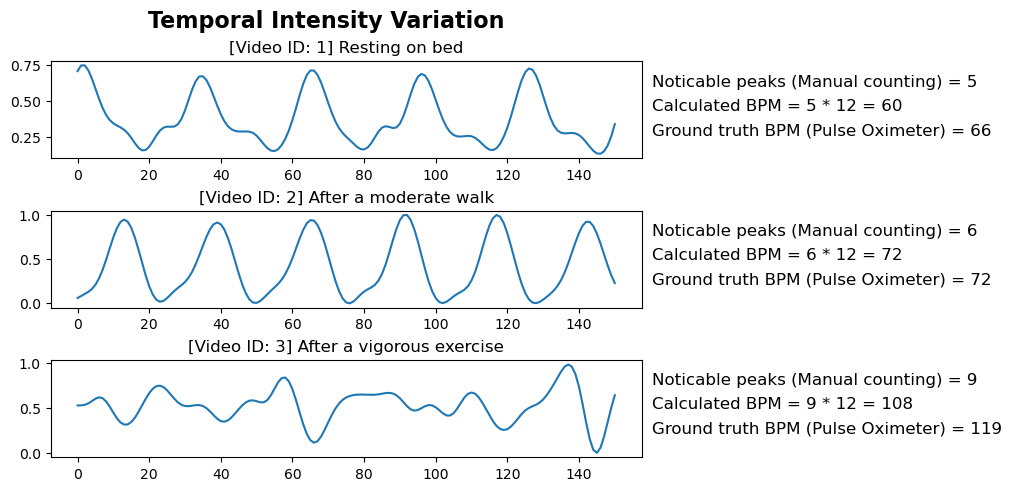

In [54]:
CHUNK_DURATION_SECS = 5

plt.rcParams['figure.constrained_layout.use'] = True

plt.subplot(3,1,1)
vid = 1
chunk_n_frames = int(CHUNK_DURATION_SECS * videoMeta[vid]["FPS"])
total_n_frames = videoMeta[vid]["FrameCount"]
chunk_idx_begin = chunk_n_frames * np.random.randint(0, total_n_frames/chunk_n_frames)
chunk_idx_end = chunk_idx_begin + chunk_n_frames
plot_data = sensingMetricTS[vid][chunk_idx_begin:chunk_idx_end]
plt.plot(plot_data)
plt.title(f"[Video ID: {vid}] Resting on bed")

plt.subplot(3,1,2)
vid = 2
chunk_n_frames = int(CHUNK_DURATION_SECS * videoMeta[vid]["FPS"])
total_n_frames = videoMeta[vid]["FrameCount"]
chunk_idx_begin = chunk_n_frames * np.random.randint(0, total_n_frames/chunk_n_frames)
chunk_idx_end = chunk_idx_begin + chunk_n_frames
plot_data = sensingMetricTS[vid][chunk_idx_begin:chunk_idx_end]
plt.plot(plot_data)
plt.title(f"[Video ID: {vid}] After a moderate walk")

plt.subplot(3,1,3)
vid = 3
chunk_n_frames = int(CHUNK_DURATION_SECS * videoMeta[vid]["FPS"])
total_n_frames = videoMeta[vid]["FrameCount"]
chunk_idx_begin = chunk_n_frames * np.random.randint(0, total_n_frames/chunk_n_frames)
chunk_idx_end = chunk_idx_begin + chunk_n_frames
plot_data = sensingMetricTS[vid][chunk_idx_begin:chunk_idx_end]
plt.plot(plot_data)
plt.title(f"[Video ID: {vid}] After a vigorous exercise")

plt.figtext(1.01, 0.83, "Noticable peaks (Manual counting) = 5", fontsize=12)
plt.figtext(1.01, 0.83-0.05, "Calculated BPM = 5 * 12 = 60", fontsize=12)
plt.figtext(1.01, 0.83-2*0.05, "Ground truth BPM (Pulse Oximeter) = 66", fontsize=12)

plt.figtext(1.01, 0.52, "Noticable peaks (Manual counting) = 6", fontsize=12)
plt.figtext(1.01, 0.52-0.05, "Calculated BPM = 6 * 12 = 72", fontsize=12)
plt.figtext(1.01, 0.52-2*0.05, "Ground truth BPM (Pulse Oximeter) = 72", fontsize=12)

plt.figtext(1.01, 0.21, "Noticable peaks (Manual counting) = 9", fontsize=12)
plt.figtext(1.01, 0.21-0.05, "Calculated BPM = 9 * 12 = 108", fontsize=12)
plt.figtext(1.01, 0.21-2*0.05, "Ground truth BPM (Pulse Oximeter) = 119", fontsize=12)

plt.suptitle("Temporal Intensity Variation", fontsize=16, fontweight='bold')
plt.show()

#### D. Likelihood Distributions [20 marks]
In the 5-second chunks taken above, choose 20 frames where your sensing metric is close to the local maximum (Case1), and 20 frames where it is close to the local minimum (Case2). Plot the histograms on "R", "G" and "B" values for each pixel in the 20 frames for the two cases 1 and 2. For each video there will be 3 figures, each for "R", "G" and "B". Which one produces the most separable distributions?

In [20]:
## put your snippet here with complete explanation in comments
## Marks will be provided based on code readability (not yourself, but others) and detailed comments


#### E. Threshold Based Detection and ROC curve [25 marks]
Only consider the "R" channel for analysis. Suppose, we just use a single pixel (uniformly randomly chosen in the frame) to detect whether the frame belongs to case 1 or case 2. You can denote the "Case 1" to be the POSITIVE event/hypothesis and "Case 2" to be the NEGATIVE event/null hypothesis. For every threshold value, for every frame, choose 500 random pixels. Compute the "Probability of Detection" ($P_D$) and "Probability of False Alarm" ($P_{FA}$). Note that you have (20 + 20) = 40 frames, and 500 detections per frame, i.e., 20000 total detections. Plot the $ROC$ curve. Which one has the best ROC curve (Dataset 1, 2 or 3)?

In [21]:
## put your snippet here with complete explanation in comments
## Marks will be provided based on code readability (not yourself, but others) and detailed comments


#### F. Are "good" samples spatially correlated? [20 marks]
First, choose an optimal threshold, $T_{OPT}$, that best suits your data (maximize $P_D$ while minimizing $P_{FA}$, you may look into maximizing the $\frac{P_D}{P_{FA}}$ ratio). Out of the 20000 total detections above for $T_{OPT}$, can it be hypothesised that the "good" samples (true positives and true negatives) are spatially clustered in certain areas of the frame, compared to the "bad" samples (false positives and false negatives)?

In [22]:
## put your snippet here with complete explanation in comments
## Marks will be provided based on code readability (not yourself, but others) and detailed comments

#### Submission (report document: 10 marks)
##### Deadline: $4^{th}$, March, 2023
* Compress the top level directory (ZIP format) containing this notebook with filled-in code along with the ppgvideos folder.
* Include a PDF file (10 marks) within the directory, name it "report.pdf". Mention your name and roll number.
* The report should contain explanations related to the above assignments (A through F), assumptions if any, specific code explanations, algorithms used and inferences made from the plots. Also include references if any.
* <b>You MUST not consult your homework code with others</b>. Any plagiarism found in your code (or somebody who is referring to your code) will result in zero credits in this assignment.
* Submissions after the deadline will not be entertained.